# Exploratory Analysis and Additional Pre-Processing

## Modules and functions

Import all the modules:

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")

from IPython.display import display, HTML

from notebooks import *

Define some functions that will be used afterwards **(you should skip this part for now)**:

In [2]:
def display_na_table(target):
    """
    Display a table with the count and the percentage of missing values per column.
    
    Arguments:
    target -- the pandas dataframe from which the frequencies are calculated
    """
    df_na = target.isna().sum()
    df_na = df_na[df_na > 0]
    df_na_t = pd.DataFrame([df_na, df_na / len(target) * 100]).transpose()
    df_na_t.columns = ["count", "percent"]
    display(df_na_t)

In [3]:
def na_row_matches_by_column(target, columns):
    """
    Take every pair of column and check if the rows with missing values match.
    
    Arguments:
    target -- the pandas dataframe from which the missing values are counted
    columns -- list of column names to match
    """
    non_matches = []
    for i, column_i in enumerate(columns):
        for j, column_j in enumerate(columns[i + 1:], start=1 + 1):
            if any(target[column_i].isna() != target[column_j].isna()):
                non_matches.append((column_i, column_j))
                
    if len(non_matches) > 0:
        print("Non matching columns found!")
        for column_i, column_j in non_matches:
            print(column_i, "and", column_j)
    else:
        print("All columns match.")

In [4]:
def add_ratio_column(target, numerator_column, denominator_column, ratio_column, fillna=False):
    """
    Adds a column resulting from the divition of two columns.
    
    Arguments:
    target -- the pandas dataframe to compute from and add to the new column
    numerator_column -- the column used as the numerator for the division
    denominator_column -- the column used as the denominator for the division
    ratio_column -- name of the new column to be added
    fillna -- True in case the missing values should be filled with zeros
    """
    target[ratio_column] = target[numerator_column] / target[denominator_column]
    
    if fillna:
        target[ratio_column] = target[ratio_column].fillna(0)

In [5]:
def categorical_counts(target_positive, target_negative, dictionary, column_prefix, limit=10, value_len_limit=30):
    """
    Display a table with the contract count per value of a categorical variable.
    
    Arguments:
    target_positive -- the pandas dataframe from which the positive counts are computed
    target_negative -- the pandas dataframe from which the negative counts are computed
    dictionary -- value definition of the categorical variable
    column_prefix -- column prefix of the categorical variable in the dataframes
    limit -- maximum amount of rows to show
    value_len_limit -- maximum amount of value characters to show
    """
    items = []
    for id_, value in enumerate(dictionary["index_to_name"]):
        column = column_prefix + str(id_)
        positive_count = target_positive[column].sum()
        items.append((id_, value, positive_count))
        
    items = sorted(items, key=lambda item: item[2], reverse=True)[:limit]

    ids, values, positive_counts = zip(*items)
    
    short_values = []
    for value in values:
        if len(value) > value_len_limit + 3:
            value = value[:(value_len_limit - 3)] + "..."
        short_values.append(value)
    
    total_counts = []
    negative_counts = []
    for id_, _, positive_count in items:
        column = column_prefix + str(id_)
        negative_count = target_negative[column].sum()
        negative_counts.append(negative_count)
        
        total_counts.append(positive_count + negative_count)

    df_counts = pd.DataFrame({
        "Value": short_values,
        "Honeypot": positive_counts,
        "Non-Honeypot": negative_counts,
        "Total": total_counts
    })
    
    display(HTML(df_counts.to_html(index=False)))

## Loading

Load all the dictionaries:

In [6]:
honey_badger_labels = load_dictionary("honey_badger_labels.pickle")
contract_compiler_major_versions = load_dictionary("contract_compiler_major_versions.pickle")
contract_compiler_minor_versions = load_dictionary("contract_compiler_minor_versions.pickle")
contract_compiler_patch_versions = load_dictionary("contract_compiler_patch_versions.pickle")
contract_libraries = load_dictionary("contract_libraries.pickle")
fund_flow_cases = load_dictionary("fund_flow_cases.pickle")

In [7]:
fund_flow_cases.keys()

dict_keys(['index_to_name', 'name_to_index'])

Load the dataset:

In [8]:
df_file_path = "dataset.csv"
df = pd.read_csv(df_file_path, low_memory=False)

Dataset dimensions:

In [9]:
print_dimensions(df)

The dataset has 2019434 rows and 290 columns


List all the columns:

In [10]:
for column in df.columns:
    print(column)

contract_address
contract_has_source_code
contract_has_byte_code
contract_has_money_flow
contract_compiler_runs
contract_num_source_code_lines
contract_label_index
contract_compiler_major_version_index
contract_compiler_minor_version_index
contract_compiler_patch_index
contract_library_index
normal_transaction_count
normal_transaction_block_count
normal_transaction_before_creation_count
normal_transaction_from_other_count
normal_transaction_other_sender_count
normal_transaction_first_block
normal_transaction_last_block
normal_transaction_block_span
normal_transaction_count_per_block_mean
normal_transaction_count_per_block_std
normal_transaction_value_mean
normal_transaction_value_std
normal_transaction_gas_mean
normal_transaction_gas_std
normal_transaction_gas_used_mean
normal_transaction_gas_used_std
normal_transaction_time_delta_mean
normal_transaction_time_delta_std
normal_transaction_block_delta_mean
normal_transaction_block_delta_std
internal_transaction_count
internal_transaction

## Check that all contracts have creation transaction

In [11]:
has_creation = fund_flow_case_columns_accumulated_frequency(fund_flow_cases, df, creation=True) > 0
print(has_creation.value_counts())

True    2019434
dtype: int64


## Labels

Create binary label:

In [12]:
df["contract_is_honeypot"] = (df.contract_label_index > 0)

In [13]:
df.contract_is_honeypot.value_counts()

False    2019139
True         295
Name: contract_is_honeypot, dtype: int64

Label distribution (only for honeypot contracts):

In [14]:
honeypot_value_counts = df.contract_label_index[df.contract_is_honeypot].value_counts()
honeypot_value_counts

2    135
4     43
8     39
6     31
1     20
3     13
5     10
7      4
Name: contract_label_index, dtype: int64

Define a color by honeypot type for the plots:

In [15]:
honeypot_colors_by_frequency = plt.get_cmap("Set2").colors[:len(honeypot_value_counts)]

honeypot_color_by_label_index = {}
for (label_index, label_count), color in zip(honeypot_value_counts.iteritems(), honeypot_colors_by_frequency):
    honeypot_color_by_label_index[label_index] = color

Plot honeypot label (technique) distribution:

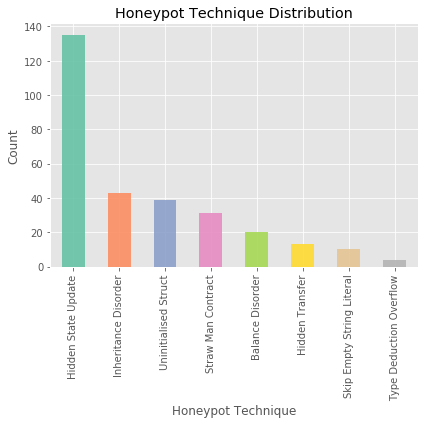

In [16]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1,1,1)
fig.set_tight_layout(True)
honeypot_value_counts.plot.bar(alpha=0.9, color=honeypot_colors_by_frequency)
plt.xticks(range(len(honeypot_value_counts)),
          [honey_badger_labels["index_to_name"][label_index] for label_index in honeypot_value_counts.keys()])

plt.title("Honeypot Technique Distribution")
plt.xlabel("Honeypot Technique")
plt.ylabel("Count")
plt.show()

## Drop unused fund flow columns

In [17]:
non_fund_flow_columns = [column for column in df.columns
                         if not column.startswith("symbol_")]

print("Number of non fund flow case columns:", len(non_fund_flow_columns))

Number of non fund flow case columns: 47


In [18]:
print("Number of fund flow case columns:", len(fund_flow_cases["index_to_name"]))

Number of fund flow case columns: 244


In [19]:
fund_flow_case_columns = []
for fund_flow_case_column in fund_flow_case_columns_with_fixed_values(fund_flow_cases):
    if df[fund_flow_case_column].sum() > 0:
        fund_flow_case_columns.append(fund_flow_case_column)
        
print("Number of used fund flow case columns:", len(fund_flow_case_columns))

Number of used fund flow case columns: 141


In [20]:
print("Number of unused fund flow case columns:",
      len(fund_flow_cases["index_to_name"]) - len(fund_flow_case_columns))

Number of unused fund flow case columns: 103


In [21]:
df = df[non_fund_flow_columns + fund_flow_case_columns]

print("The dataset has {:d} rows and {:d} columns after removing unused fund flow case columns".format(*df.shape))

The dataset has 2019434 rows and 188 columns after removing unused fund flow case columns


## Statistics for numerical variables

In [22]:
df[non_fund_flow_columns].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
contract_compiler_runs,216503.0,2.934852e+04,3.091385e+06,0.0,2.000000e+02,2.000000e+02,2.000000e+02,3.300000e+08
contract_num_source_code_lines,2019434.0,2.854300e+01,1.120118e+02,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.140900e+04
contract_label_index,2019434.0,5.333178e-04,5.181817e-02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00
contract_compiler_major_version_index,216503.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
contract_compiler_minor_version_index,216503.0,4.710466e-01,8.496020e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
contract_compiler_patch_index,216503.0,6.392920e+01,7.926257e+01,0.0,0.000000e+00,1.900000e+01,1.350000e+02,3.290000e+02
contract_library_index,6059.0,6.401523e+02,1.804919e+02,0.0,6.415000e+02,7.340000e+02,7.340000e+02,7.480000e+02
normal_transaction_count,2019434.0,6.994269e+01,9.526084e+03,1.0,1.000000e+00,1.000000e+00,2.000000e+00,1.041294e+07
normal_transaction_block_count,2019434.0,3.504458e+01,2.321645e+03,1.0,1.000000e+00,1.000000e+00,2.000000e+00,1.654014e+06
normal_transaction_before_creation_count,2019434.0,5.471830e-04,7.648112e-02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,7.700000e+01


(Non fund flow case variables that are not numerical are not described)

## Transaction counts

Validate that there are no contracts with zero normal transactions:

(This should hold because we already verified that every contract has a creation transaction)

In [23]:
len(df[df.normal_transaction_count == 0])

0

Contracts with only the creation transaction:

In [24]:
has_one_normal_transaction = df.normal_transaction_count == 1
count_has_one_normal_transaction = len(df[has_one_normal_transaction])

print("Number of contracts with only one normal transaction: {:d} ({:.03f} %)".format(
    count_has_one_normal_transaction, count_has_one_normal_transaction * 100 / len(df)))

Number of contracts with only one normal transaction: 1352839 (66.991 %)


Contract with no internal transactions:

In [25]:
has_internal_transactions = df.internal_transaction_count > 0
has_no_internal_transactions = df.internal_transaction_count == 0
count_has_no_internal_transactions = len(df[has_no_internal_transactions])

print("Number of contracts with zero internal transactions: {:d} ({:.03f} %)".format(
    count_has_no_internal_transactions, count_has_no_internal_transactions * 100 / len(df)))

Number of contracts with zero internal transactions: 1651344 (81.773 %)


## Block span

Across how many blocks the non-honeypot contracts live?

In [26]:
df[~df.contract_is_honeypot].normal_transaction_block_count.describe().apply("{:.2f}".format)

count    2019139.00
mean          35.05
std         2321.82
min            1.00
25%            1.00
50%            1.00
75%            2.00
max      1654014.00
Name: normal_transaction_block_count, dtype: object

What about the honeypot contracts?

In [27]:
df[df.contract_is_honeypot].normal_transaction_block_count.describe().apply("{:.2f}".format)

count    295.00
mean       5.05
std        4.12
min        1.00
25%        3.00
50%        4.00
75%        6.00
max       29.00
Name: normal_transaction_block_count, dtype: object

Total block span per honeypot technique:

In [28]:
block_span_per_label = df.groupby("contract_label_index").agg({"normal_transaction_first_block": "min",
                                                            "normal_transaction_last_block": "max"})

block_span_per_label["length"] = block_span_per_label["normal_transaction_last_block"] - block_span_per_label["normal_transaction_first_block"]

block_span_per_label

,normal_transaction_first_block,normal_transaction_last_block,length
contract_label_index,,,
0,46402,6500000,6453598
1,4471773,5614658,1142885
2,3056072,6484443,3428371
3,5019154,5974752,955598
4,4228297,6429732,2201435
5,5031443,6017570,986127
6,4470038,6484578,2014540
7,4528158,6050175,1522017
8,5031217,6384035,1352818


Let's plot the total block span per honeypot technique:

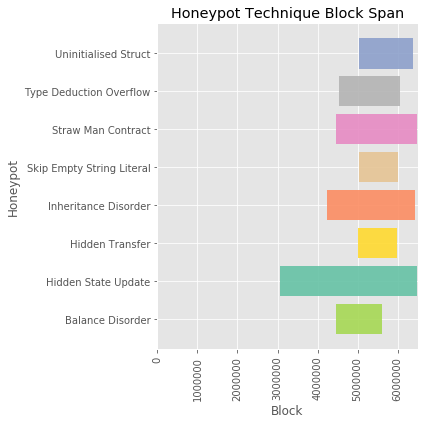

In [29]:
honeypot_block_span_per_label = block_span_per_label[block_span_per_label.index > 0]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1,1,1)
fig.set_tight_layout(True)

plt.barh(range(len(honeypot_block_span_per_label)),
         honeypot_block_span_per_label["length"].values,
         left=honeypot_block_span_per_label["normal_transaction_first_block"].values,
         color=[honeypot_color_by_label_index[label_index] for label_index in honeypot_block_span_per_label.index],
         alpha=0.9)

plt.yticks(range(len(honeypot_block_span_per_label)),
           [honey_badger_labels["index_to_name"][label_index]
            for label_index in honeypot_block_span_per_label.index])

for label in ax.get_xticklabels():
    label.set_rotation(90)
    
plt.xlim(0, 6500000)

plt.title("Honeypot Technique Block Span")
plt.xlabel("Block")
plt.ylabel("Honeypot")
plt.show()

## Missing values

There are several columns with missing values, and they can be grouped by the misssing value count:

In [30]:
display_na_table(df)

,count,percent
contract_has_money_flow,57663.0,2.855404
contract_compiler_runs,1802931.0,89.279026
contract_compiler_major_version_index,1802931.0,89.279026
contract_compiler_minor_version_index,1802931.0,89.279026
contract_compiler_patch_index,1802931.0,89.279026
contract_library_index,2013375.0,99.699965
normal_transaction_value_mean,26253.0,1.300018
normal_transaction_value_std,26253.0,1.300018
normal_transaction_time_delta_mean,1352839.0,66.990998
normal_transaction_time_delta_std,1352839.0,66.990998


### Missing values from source features:

There are missing values in the source code features when there is no source code.

They only feature that is expected to have missing values, is the library, just because sometimes a contract does not use one.

These are the affected features:

In [31]:
source_code_na_columns = [
    "contract_compiler_runs",
    "contract_num_source_code_lines",
    "contract_compiler_major_version_index",
    "contract_compiler_minor_version_index",
    "contract_compiler_patch_index",
    "contract_library_index"
]

When counting missing values for those features only for contracts with source code:

In [32]:
display_na_table(df.loc[df.contract_has_source_code, source_code_na_columns])

,count,percent
contract_library_index,210444.0,97.201424


### Value aggregated columns from normal transactions:

According to the feature engineering, the only way a contract has no mean or no std for the normal transaction values, is if the contract don't have any value movement in their normal transactions (not even a value of zero). This can only happen when all the transactions of the contract have errors.

Check when the normal transaction value mean and std have missing values:

In [33]:
columns_normal_value_aggregated = [
    "normal_transaction_value_mean",
    "normal_transaction_value_std"
]

All the rows should match:

In [34]:
na_row_matches_by_column(df, columns_normal_value_aggregated)

All columns match.


As they have missing values in the same rows, take any of those columns to get the rows with missing values:

In [35]:
na_rows_normal_value_aggregated = df[columns_normal_value_aggregated[0]].isna()

All the contracts without normal value mean (or std) have transactions with errors:

In [36]:
all(fund_flow_case_columns_accumulated_frequency(fund_flow_cases,
                                                 df[na_rows_normal_value_aggregated],
                                                 error=True) > 0)

False

And all the contracts without normal value mean (or std) have no transactions without errors:

In [37]:
all(fund_flow_case_columns_accumulated_frequency(fund_flow_cases,
                                                 df[na_rows_normal_value_aggregated],
                                                 error=False) == 0)

False

### Delta aggregated columns from normal transactions:

In [38]:
columns_normal_delta_aggregated = [
    "normal_transaction_time_delta_mean",
    "normal_transaction_time_delta_std",
    "normal_transaction_block_delta_mean",
    "normal_transaction_block_delta_std",
]

Validate that they have missing values in the exact same rows (pair by pair):

In [39]:
na_row_matches_by_column(df, columns_normal_delta_aggregated)

All columns match.


As they have missing values in the same rows, take any of those columns to get the rows with missing values:

In [40]:
na_rows_normal_delta_aggregated = df[columns_normal_delta_aggregated[0]].isna()

Validate that the delta aggregated columns from normal transactions have missing values exactly when there is only one normal transaction

(because time and block deltas can be only computed between two consecutive transactions): 

In [41]:
all(has_one_normal_transaction == na_rows_normal_delta_aggregated)

True

### Aggregated columns from internal transactions (except the value):

All the aggregated features from internal transactions have NA when there are no internal transactions:

(ignoring the values that are a special case)

In [42]:
columns_internal_aggregated = [
    "internal_transaction_count_per_block_mean",
    "internal_transaction_count_per_block_std",
    "internal_transaction_gas_mean",
    "internal_transaction_gas_std",
    "internal_transaction_gas_used_mean",
    "internal_transaction_gas_used_std",
]

In [43]:
na_row_matches_by_column(df, columns_internal_aggregated)

All columns match.


As they have missing values in the same rows, take any of those columns to get the rows with missing values:

In [44]:
na_rows_internal_aggregated = df[columns_internal_aggregated[0]].isna()

Validate that the aggregated columns from internal transactions have missing values when there are no internal transactions: 

In [45]:
all(has_no_internal_transactions == na_rows_internal_aggregated)

True

### Value aggregated columns from internal transactions:

This is similar to the value aggregated columns from the normal transactions, but we need to separate the contracts that have no internal transactions at all.

All the contracts without internal transactions have missing internal transaction value mean and std:

In [46]:
print("mean:", all(df[has_no_internal_transactions].internal_transaction_value_mean.isna()))
print("std:", all(df[has_no_internal_transactions].internal_transaction_value_std.isna()))

mean: True
std: True


Check when the internal transaction value mean and std have missing values (when they have internal transactions):

In [47]:
internal_na_value_mean = df.internal_transaction_value_mean.isna() & has_internal_transactions
internal_na_value_std = df.internal_transaction_value_std.isna() & has_internal_transactions

All the rows should match:

In [48]:
all(internal_na_value_mean == internal_na_value_std)

True

All the contracts with internal transactions but without internal value mean (or std) have transactions with errors:

In [49]:
all(fund_flow_case_columns_accumulated_frequency(fund_flow_cases,
                                                 df[internal_na_value_mean],
                                                 error=True) > 0)

False

### Filling missing values

Fill with zeros the value aggregated columns from normal transactions:

In [50]:
df.loc[na_rows_normal_value_aggregated, columns_normal_value_aggregated] = \
    df.loc[na_rows_normal_value_aggregated, columns_normal_value_aggregated].fillna(0.0)

Fill with zeros the delta aggregated columns from normal transactions:

In [51]:
df.loc[na_rows_normal_delta_aggregated, columns_normal_delta_aggregated] = \
    df.loc[na_rows_normal_delta_aggregated, columns_normal_delta_aggregated].fillna(0.0)

Fill with zeros the aggregated columns from internal transactions (except the value):

In [52]:
df.loc[na_rows_internal_aggregated, columns_internal_aggregated] = \
    df.loc[na_rows_internal_aggregated, columns_internal_aggregated].fillna(0.0)

Fill with zeros the value aggregated columns from internal transactions:

In [53]:
df.loc[:, "internal_transaction_value_mean"] = df.loc[:, "internal_transaction_value_mean"].fillna(0.0)
df.loc[:, "internal_transaction_value_std"] = df.loc[:, "internal_transaction_value_std"].fillna(0.0)

Now the missing values are only related to byte code and source code presence:

The only one that has missing values is the library (because some contracts just don't use one)

In [54]:
display_na_table(df[df.contract_has_source_code & df.contract_has_byte_code])

,count,percent
contract_library_index,152804.0,96.186022


## Normalize numeric

List the features that MIGHT need to be normalized:

In [55]:
known_ignored_columns = [
    "contract_address",
    "contract_evaluation_positive",
    "contract_label_name",
    "contract_is_honeypot",
    "normal_transaction_first_block",
    "normal_transaction_last_block"
]

columns_to_normalize = set()

ignored_column_suffixes = ["_mean", "_std", "_index"]
ignored_column_infixes = ["_has_"]
for column in non_fund_flow_columns:
    ignore_column = False
    
    for known_ignored_column in known_ignored_columns:
        if column == known_ignored_column:
            ignore_column = True
            
    if not ignore_column:
        for ignored_column_suffix in ignored_column_suffixes:
            if column.endswith(ignored_column_suffix):
                ignore_column = True
                break
                
    if not ignore_column:
        for ignored_column_infix in ignored_column_infixes:
            if ignored_column_infix in column:
                ignore_column = True
                break
                
    if not ignore_column:
        columns_to_normalize.add(column)
        print(column)

contract_compiler_runs
contract_num_source_code_lines
normal_transaction_count
normal_transaction_block_count
normal_transaction_before_creation_count
normal_transaction_from_other_count
normal_transaction_other_sender_count
normal_transaction_block_span
internal_transaction_count
internal_transaction_block_count
internal_transaction_creation_count
internal_transaction_from_other_count
internal_transaction_other_sender_count
internal_transaction_to_other_count
internal_transaction_other_receiver_count


### Transform into ratios some of the counts

Ratio of blocks per normal transaction.

This will normalize the normal transaction block count to be comparable between contracts of different number of normal transactions.

Nevertheless, this is not a number in the range \[0, 1\], so it is not normalized yet:

In [56]:
add_ratio_column(df,
                 "normal_transaction_block_count",
                 "normal_transaction_count",
                 "normal_transaction_block_ratio",
                 fillna=False)

columns_to_normalize.remove("normal_transaction_block_count")

Ratio of normal transactions made before the creation over the total amount of normal transactions.

The range of this new feature is \[0, 1\], with a value of 0 when there are no transactions before creation, 1 when all the normal transactions were made before the creation, and an internediate value when there are transactions before and after the creation:

In [57]:
add_ratio_column(df,
                 "normal_transaction_before_creation_count",
                 "normal_transaction_count",
                 "normal_transaction_before_creation_ratio",
                 fillna=False)

columns_to_normalize.remove("normal_transaction_before_creation_count")

Ratio of normal transactions from other sender over the total amount of normal transactions.

The range of this new feature is \[0, 1\], with a value of 0 when there are no transactions from other sender, 1 when all the normal transactions are from other sender, and an internediate value when there are transactions from the creator and other sender:

In [58]:
add_ratio_column(df,
                 "normal_transaction_from_other_count",
                 "normal_transaction_count",
                 "normal_transaction_from_other_ratio",
                 fillna=False)

columns_to_normalize.remove("normal_transaction_from_other_count")

Ratio of the number different non-creator normal transaction senders over the total amount of normal transactions from a non-creator sender.

The range of this new feature is \[0, 1\]. If a contract has no normal transactions sent from non-creator accounts the ratio is undefined but we arbitrarily define it as 0. The value will be 1 / normal_transaction_from_other_count when there is only one non-creator sender, and will grow while the amount of unique non-creator senders grow, with a max value of 1 when all the normal transactions coming from a non-creator account have different senders:

In [59]:
add_ratio_column(df,
                 "normal_transaction_other_sender_count",
                 "normal_transaction_from_other_count",
                 "normal_transaction_other_sender_ratio",
                 fillna=True)  # when normal_transaction_from_other_count=0

columns_to_normalize.remove("normal_transaction_other_sender_count")

Ratio of blocks per internal transaction.

This will normalize the internal transaction block count to be comparable between contracts of different number of internal transactions.

Nevertheless, this is not a number in the range \[0, 1\].

Also note that if a contract has no internal transactions, the ratio is undefined.

We can fill those cases with zeros:

In [60]:
add_ratio_column(df,
                 "internal_transaction_block_count",
                 "internal_transaction_count",
                 "internal_transaction_block_ratio",
                 fillna=True)  # when internal_transaction_count=0

columns_to_normalize.remove("internal_transaction_block_count")

Ratio of internal transactions that create another contract over the total amount of internal transactions.

The range of this new feature is \[0, 1\], with a value of 0 when there are no internal transactions create another contract, 1 when all the internal transactions create another contract, and an internediate value when some but not all the internal transactions create another contract.

Also note that if a contract has no internal transactions, the ratio is undefined.

We can fill those cases with zeros:

In [61]:
add_ratio_column(df,
                 "internal_transaction_creation_count",
                 "internal_transaction_count",
                 "internal_transaction_creation_ratio",
                 fillna=True)  # when internal_transaction_count=0

columns_to_normalize.remove("internal_transaction_creation_count")

Ratio of internal transactions from other sender over the total amount of internal transactions.

The range of this new feature is \[0, 1\], with a value of 0 when there are no transactions from other sender, 1 when all the internal transactions are from other sender, and an internediate value when there are transactions from the creator and other sender:

Also note that if a contract has no internal transactions, the ratio is undefined.

We can fill those cases with zeros:

In [62]:
add_ratio_column(df,
                 "internal_transaction_from_other_count",
                 "internal_transaction_count",
                 "internal_transaction_from_other_ratio",
                 fillna=True)  # when internal_transaction_count=0

columns_to_normalize.remove("internal_transaction_from_other_count")

Ratio of the number different non-creator internal transaction senders over the total amount of internal transactions from a non-creator sender.

The range of this new feature is \[0, 1\]. If a contract has no internal transactions sent from non-creator accounts the ratio is undefined but we arbitrarily define it as 0. The value will be 1 / internal_transaction_from_other_count when there is only one non-creator sender, and will grow while the amount of unique non-creator senders grow, with a max value of 1 when all the internal transactions coming from a non-creator account have different senders:

In [63]:
add_ratio_column(df,
                 "internal_transaction_other_sender_count",
                 "internal_transaction_from_other_count",
                 "internal_transaction_other_sender_ratio",
                 fillna=True)  # when internal_transaction_from_other_count=0

columns_to_normalize.remove("internal_transaction_other_sender_count")

Internal transactions can have a receiver different than the contract.

This is the ratio of internal transactions to another receiver over the total amount of internal transactions.

The range of this new feature is \[0, 1\], with a value of 0 when there are no transactions to another receiver, 1 when all the internal transactions go to another receiver, and an internediate value when there are transactions to the creator and to another receiver:

Also note that if a contract has no internal transactions, the ratio is undefined.

We can fill those cases with zeros:

In [64]:
add_ratio_column(df,
                 "internal_transaction_to_other_count",
                 "internal_transaction_count",
                 "internal_transaction_to_other_ratio",
                 fillna=True)  # when internal_transaction_count=0

columns_to_normalize.remove("internal_transaction_to_other_count")

Ratio of the number different non-creator internal transaction receivers over the total amount of internal transactions to a non-creator receiver.

The range of this new feature is \[0, 1\]. If a contract has no internal transactions sent to non-creator accounts the ratio is undefined but we arbitrarily define it as 0. The value will be 1 / internal_transaction_to_other_count when there is only one non-creator receiver, and will grow while the amount of unique non-creator receivers grow, with a max value of 1 when all the internal transactions going to a non-creator account have different receivers:

In [65]:
add_ratio_column(df,
                 "internal_transaction_other_receiver_count",
                 "internal_transaction_to_other_count",
                 "internal_transaction_other_receiver_ratio",
                 fillna=True)  # when internal_transaction_to_other_count=0

columns_to_normalize.remove("internal_transaction_other_receiver_count")

### Columns that still might need to be normalized

In [66]:
for column in sorted(columns_to_normalize):
    print(column)

contract_compiler_runs
contract_num_source_code_lines
internal_transaction_count
normal_transaction_block_span
normal_transaction_count


## One-hot-encoding the categorical variables

These are the columns that need to be one-hot-encoded.

We don't encode the mayor version of the contract compiler because it has only one possible value.

In [67]:
columns_to_one_hot_encode = [
    "contract_compiler_minor_version_index",
    "contract_compiler_patch_index",
    "contract_library_index"
]

Go column by column, create dummy variables and append them to the dataset.

The prefix is the original name of the column without the "_index" suffix:

In [68]:
columns_one_hot_encoded = []

for column in columns_to_one_hot_encode:
    dummies = pd.get_dummies(df[column], prefix=column.replace("_index", ""))
    columns_one_hot_encoded.extend(dummies.columns)
    df = pd.concat([df, dummies], axis=1)

The names of the columns contain a undesirable ".0" suffix because at some point the dictionary IDs were transformed into floats.

We just correct that by renaming the columns:

In [69]:
column_rename = {}
for i, column in enumerate(columns_one_hot_encoded):
    new_column = column.replace(".0", "")
    columns_one_hot_encoded[i] = column
    column_rename[column] = new_column
df = df.rename(columns=column_rename)
del column_rename  # free some memory

## Categorical variables crossed with binary label

Split the dataset into honeypot (positive) and non-honeypot (negative):

In [70]:
df_positive = df[df.contract_is_honeypot]
df_negative = df[~df.contract_is_honeypot]

Cross the contract compiler minor version with the binary label:

In [71]:
pd.crosstab(~df.contract_compiler_minor_version_index.isna(),
            df.contract_is_honeypot,
            rownames=["contract_has_compiler_version_minor"])

contract_is_honeypot,False,True
contract_has_compiler_version_minor,,
False,1802931,0
True,216208,295


Contract count for all the compiler minor versions:

In [72]:
categorical_counts(df_positive,
                   df_negative,
                   contract_compiler_minor_versions,
                   "contract_compiler_minor_version_")

Value,Honeypot,Non-Honeypot,Total
4,294,165266,165560
3,1,50787,50788
1,0,29,29
2,0,126,126


Cross the contract compiler patch version with the binary label:

In [73]:
pd.crosstab(~df.contract_compiler_patch_index.isna(),
            df.contract_is_honeypot,
            rownames=["contract_has_compiler_version_patch"])

contract_is_honeypot,False,True
contract_has_compiler_version_patch,,
False,1802931,0
True,216208,295


Contract count for the top five most common compiler patch versions among honeypots:

In [74]:
categorical_counts(df_positive,
                   df_negative,
                   contract_compiler_patch_versions,
                   "contract_compiler_patch_",
                   limit=5)

Value,Honeypot,Non-Honeypot,Total
19+commit.c4cbbb05,124,9950,10074
20+commit.3155dd80,62,2937,2999
24+commit.e67f0147,26,90428,90454
18+commit.9cf6e910,19,7187,7206
17+commit.bdeb9e52,12,751,763


Contract count for the top five most common libraries among honeypots:

In [75]:
categorical_counts(df_positive,
                   df_negative,
                   contract_libraries,
                   "contract_library_",
                   limit=5)

Value,Honeypot,Non-Honeypot,Total
GroveLib:d07ce4329b27eb8896...,0,1,1
AccountingLib:7de615d8a5174...,0,1,1
SchedulerLib:e54d323f9ef17c...,0,1,1
GroveLib:7c1eb207c07e7ab13c...,0,1,1
AccountingLib:89efe605e9ecb...,0,1,1


## Booleans crossed with the Binary Label

Create a feature indicating if the library is defined:

In [76]:
df["contract_has_library"] = ~df.contract_library_index.isna()

Cross the library binary flag with the binary label:

In [77]:
pd.crosstab(df.contract_has_library, df.contract_is_honeypot)

contract_is_honeypot,False,True
contract_has_library,,
False,2013080,295
True,6059,0


It makes sense that honeypot contracts always have byte code.

The ones without byte code don't work at all, they are errors.

In [78]:
pd.crosstab(df.contract_has_byte_code, df.contract_is_honeypot)

contract_is_honeypot,False,True
contract_has_byte_code,,
False,57664,0
True,1961475,295


It makes sense that honeypot contracts always have source code by the definition given in the paper.

In [79]:
pd.crosstab(df.contract_has_source_code, df.contract_is_honeypot)

contract_is_honeypot,False,True
contract_has_source_code,,
False,1802931,0
True,216208,295


Split into types depending on the existence or non-existence of internal transactions:

In [80]:
df["has_internal_transactions"] = df["internal_transaction_count"] > 0

Cross the internal transactions binary flag with the binary label:

In [81]:
pd.crosstab(df.has_internal_transactions, df.contract_is_honeypot)

contract_is_honeypot,False,True
has_internal_transactions,,
False,1651206,138
True,367933,157


## Filtering

### Filter out contracts without Source Code or Byte Code

In [82]:
df_filtered = df[df.contract_has_byte_code & df.contract_has_source_code]

Check the new size:

In [83]:
print_dimensions(df_filtered)

The dataset has 158863 rows and 1283 columns


Check the new proportion of classes:

In [84]:
df_filtered.contract_is_honeypot.value_counts()

False    158568
True        295
Name: contract_is_honeypot, dtype: int64

### Filter out columns that are not useful for machine learning

In [85]:
df_filtered = df_filtered.drop([
    # booleans that already filtered the dataset
    "contract_has_source_code",
    "contract_has_byte_code",
    
    # counts transformed into ratios
    "normal_transaction_block_count",
    "normal_transaction_before_creation_count",
    "normal_transaction_other_sender_count",
    "normal_transaction_from_other_count",
    "internal_transaction_block_count",
    "internal_transaction_creation_count",
    "internal_transaction_from_other_count",
    "internal_transaction_other_sender_count",
    "internal_transaction_to_other_count",
    "internal_transaction_other_receiver_count",
    
    # label encoded features replaced by one hot encoded features
    "contract_compiler_major_version_index",  # this was discarded for having no variance
    "contract_compiler_minor_version_index",
    "contract_compiler_patch_index",
    "contract_library_index",
    
    # not useful for machine learning, only useful for plots
    "normal_transaction_first_block",  # this was just for reference but not an acutal feature
    "normal_transaction_last_block",  # this was just for reference but not an acutal feature
], axis=1)

List the remaining columns just in case (ignoring the one hot encodings and frequencies):

In [86]:
for column in sorted(df_filtered.columns):
    if not column.startswith("contract_compiler_minor_version_") \
        and not column.startswith("contract_compiler_patch_") \
        and not column.startswith("contract_library_") \
        and not column.startswith("symbol_"):
        print(column)

contract_address
contract_compiler_runs
contract_has_library
contract_has_money_flow
contract_is_honeypot
contract_label_index
contract_num_source_code_lines
has_internal_transactions
internal_transaction_block_ratio
internal_transaction_count
internal_transaction_count_per_block_mean
internal_transaction_count_per_block_std
internal_transaction_creation_ratio
internal_transaction_from_other_ratio
internal_transaction_gas_mean
internal_transaction_gas_std
internal_transaction_gas_used_mean
internal_transaction_gas_used_std
internal_transaction_other_receiver_ratio
internal_transaction_other_sender_ratio
internal_transaction_to_other_ratio
internal_transaction_value_mean
internal_transaction_value_std
normal_transaction_before_creation_ratio
normal_transaction_block_delta_mean
normal_transaction_block_delta_std
normal_transaction_block_ratio
normal_transaction_block_span
normal_transaction_count
normal_transaction_count_per_block_mean
normal_transaction_count_per_block_std
normal_transa

### Filter out columns without variance

In [87]:
columns_ignore_variance = set([
    "contract_address",
    "contract_evaluation_positive",
    "contract_label_index",
    "contract_label_name",
])

columns_zero_variance = []
for column in df_filtered.columns:
    if column not in columns_ignore_variance:
        if df_filtered[column].var() < 1e-6:
            columns_zero_variance.append(column)
            print(column)

symbol_8
symbol_11
symbol_14
symbol_15
symbol_16
symbol_17
symbol_18
symbol_19
symbol_21
symbol_23
symbol_24
symbol_28
symbol_32
symbol_35
symbol_37
symbol_40
symbol_45
symbol_48
symbol_50
symbol_52
symbol_56
symbol_58
symbol_60
symbol_64
symbol_68
symbol_70
symbol_72
symbol_74
symbol_80
symbol_84
symbol_89
symbol_92
symbol_94
symbol_97
symbol_99
symbol_101
symbol_107
symbol_109
symbol_111
symbol_115
symbol_117
symbol_118
symbol_119
symbol_120
symbol_124
symbol_125
symbol_126
symbol_128
symbol_130
symbol_131
symbol_134
symbol_136
symbol_166
symbol_167
symbol_168
symbol_169
symbol_170
symbol_172
symbol_175
symbol_176
symbol_186
symbol_188
symbol_192
symbol_196
symbol_200
symbol_206
symbol_210
symbol_212


In [88]:
df_filtered = df_filtered.drop(columns_zero_variance, axis=1)

In [89]:
print_dimensions(df_filtered)

The dataset has 158863 rows and 1197 columns


###  Filter out the library one-hot-encoded columns

There are no honeypots with libraries.

In [90]:
library_columns = []
for column in df_filtered.columns:
    if column.startswith("contract_library_"):
        library_columns.append(column)
        print(column)

contract_library_0
contract_library_1
contract_library_2
contract_library_3
contract_library_4
contract_library_5
contract_library_6
contract_library_7
contract_library_8
contract_library_9
contract_library_10
contract_library_11
contract_library_12
contract_library_13
contract_library_14
contract_library_15
contract_library_16
contract_library_17
contract_library_18
contract_library_19
contract_library_20
contract_library_21
contract_library_22
contract_library_23
contract_library_24
contract_library_25
contract_library_26
contract_library_27
contract_library_28
contract_library_29
contract_library_30
contract_library_31
contract_library_32
contract_library_33
contract_library_34
contract_library_35
contract_library_36
contract_library_37
contract_library_38
contract_library_39
contract_library_40
contract_library_41
contract_library_42
contract_library_43
contract_library_44
contract_library_45
contract_library_46
contract_library_47
contract_library_48
contract_library_49
contract_l

In [91]:
df_filtered = df_filtered.drop(library_columns, axis=1)

In [92]:
print_dimensions(df_filtered)

The dataset has 158863 rows and 448 columns


### Filter out the internal transaction aggregated features

They have too many missing values.

In [93]:
df_filtered = df_filtered.drop([
    "internal_transaction_block_ratio",
    "internal_transaction_count_per_block_mean",
    "internal_transaction_count_per_block_std",
    "internal_transaction_creation_ratio",
    "internal_transaction_from_other_ratio",
    "internal_transaction_gas_mean",
    "internal_transaction_gas_std",
    "internal_transaction_gas_used_mean",
    "internal_transaction_gas_used_std",
    "internal_transaction_other_receiver_ratio",
    "internal_transaction_other_sender_ratio",
    "internal_transaction_to_other_ratio",
    "internal_transaction_value_mean",
    "internal_transaction_value_std",
], axis=1)

In [94]:
print_dimensions(df_filtered)

The dataset has 158863 rows and 434 columns


## Saving

In [95]:
df_filtered.to_csv("dataset-filtered.csv", index=False)